In [1]:
!pip install pot
!sudo apt-get update
!sudo apt-get install texlive-latex-recommended 
!sudo apt install texlive-latex-extra
!sudo apt install dvipng
!apt install cm-super
!sudo apt-get install texlive-extra-utils

     |████████████████████████████████| 664 kB 5.3 MB/s 
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [84.8 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubu

In [28]:
import ot
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [29]:
device = 'cpu'

## Loading the datasets

In [4]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32)),
    transforms.Lambda(lambda x: x.repeat([3, 1, 1]))
])

transform_svhn = transforms.Compose([transforms.ToTensor()])

In [9]:
src_dataset = datasets.MNIST(root='./.tmp', train=True, transform=transform_mnist, download=True)
src_loader = torch.utils.data.DataLoader(dataset=src_dataset, batch_size=256, shuffle=True)

tgt_dataset = datasets.SVHN(root='./.tmp', split='train', transform=transform_svhn, download=True)
tgt_loader = torch.utils.data.DataLoader(dataset=tgt_dataset, batch_size=256, shuffle=True)

Using downloaded and verified file: ./.tmp/train_32x32.mat


In [10]:
for xs, ys in src_loader: break
for xt, yt in tgt_loader: break

(-0.5, 273.5, 273.5, -0.5)

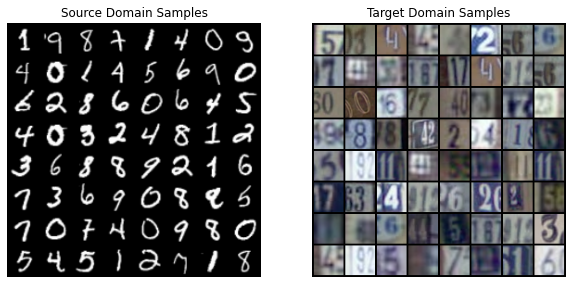

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ind = np.random.choice(np.arange(len(xs)), size=64)
samples = xs[ind]
grid = make_grid(samples).numpy().transpose([1, 2, 0])

axes[0].set_title('Source Domain Samples')
axes[0].imshow(grid)
axes[0].axis('off')

ind = np.random.choice(np.arange(len(xs)), size=64)
samples = xt[ind]
grid = make_grid(samples).numpy().transpose([1, 2, 0])

axes[1].set_title('Target Domain Samples')
axes[1].imshow(grid)
axes[1].axis('off')

## Pretraining a Feature Extractor

In [23]:
class LeNet5(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=10):
        self.n_channels = n_channels
        super(LeNet5, self).__init__()

        self.feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_channels, out_channels=32, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2),
            torch.nn.Conv2d(in_channels=32, out_channels=48, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(stride=2, kernel_size=2)
        )

        self.class_discriminator = torch.nn.Sequential(
            torch.nn.Linear(in_features=48 * 5 * 5, out_features=100),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=100, out_features=100),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=100, out_features=n_classes),
            torch.nn.Softmax(dim=1)
        )

    def extract_features(self, x):
        with torch.no_grad():
            h = self.feature_extractor(x).view(-1, 48 * 5 * 5)
            return self.class_discriminator[:-2](h)

    def forward(self, x):
        y = self.feature_extractor(x)
        h = y.view(-1, 48 * 5 * 5)
        predicted_labels = self.class_discriminator(h)

        return predicted_labels

In [24]:
model = LeNet5(n_channels=3, n_classes=10)

In [26]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [30]:
# Training loop
last_loss = 0
for it in range(10):
    accs, losses = [], []
    pbar = tqdm(src_loader)
    for x, y in pbar:
        optimizer.zero_grad()

        # Get data and pushes into device
        x, y = x.to(device), y.to(device)
        y = torch.nn.functional.one_hot(y, num_classes=10).float()

        # Forward pass
        yhat = model(x)

        # Evaluate loss
        loss = criterion(yhat, y)

        # Backward pass
        loss.backward()

        # Optimization step
        optimizer.step()

        # Append losses to list
        it_loss = loss.cpu().item()
        losses.append(it_loss)

        # Append accs to list
        it_acc = accuracy_score(y.detach().argmax(dim=1).cpu().numpy(),
                                yhat.detach().argmax(dim=1).cpu().numpy())
        accs.append(it_acc)
        pbar.set_description('Loss: {}, Acc: {}'.format(it_loss, it_acc))
    loss = np.mean(losses)
    acc = np.mean(accs)
    δloss = abs(loss - last_loss)
    print('It {}/{}, loss: {}, acc: {}, δloss: {}'.format(it + 1, 10, loss, acc, δloss))
    last_loss = loss

Loss: 1.673855185508728, Acc: 0.7916666666666666: 100%|██████████| 235/235 [01:18<00:00,  2.98it/s]


It 1/10, loss: 1.7427350627615097, acc: 0.7269226507092199, δloss: 1.7427350627615097


Loss: 1.5087321996688843, Acc: 0.9479166666666666: 100%|██████████| 235/235 [01:17<00:00,  3.04it/s]


It 2/10, loss: 1.5788505823054213, acc: 0.8834053634751774, δloss: 0.1638844804560884


Loss: 1.495896339416504, Acc: 0.96875: 100%|██████████| 235/235 [01:16<00:00,  3.06it/s]


It 3/10, loss: 1.48782182855809, acc: 0.9744015957446809, δloss: 0.09102875374733133


Loss: 1.4947296380996704, Acc: 0.96875: 100%|██████████| 235/235 [01:16<00:00,  3.05it/s]


It 4/10, loss: 1.4796751225248297, acc: 0.9822639627659574, δloss: 0.008146706033260287


Loss: 1.5094801187515259, Acc: 0.9479166666666666: 100%|██████████| 235/235 [01:16<00:00,  3.06it/s]


It 5/10, loss: 1.4771390148933898, acc: 0.9846354166666668, δloss: 0.0025361076314398545


Loss: 1.492094874382019, Acc: 0.9583333333333334: 100%|██████████| 235/235 [01:16<00:00,  3.06it/s]


It 6/10, loss: 1.4749206299477435, acc: 0.9865082003546098, δloss: 0.002218384945646301


Loss: 1.4611748456954956, Acc: 1.0: 100%|██████████| 235/235 [01:17<00:00,  3.04it/s]


It 7/10, loss: 1.4736247280810741, acc: 0.9878823138297872, δloss: 0.0012959018666693911


Loss: 1.4612106084823608, Acc: 1.0: 100%|██████████| 235/235 [01:19<00:00,  2.96it/s]


It 8/10, loss: 1.4720338846774812, acc: 0.9893450797872341, δloss: 0.0015908434035929453


Loss: 1.4612823724746704, Acc: 1.0: 100%|██████████| 235/235 [01:16<00:00,  3.06it/s]


It 9/10, loss: 1.470843687463314, acc: 0.9909242021276595, δloss: 0.0011901972141672434


Loss: 1.4664040803909302, Acc: 0.9895833333333334: 100%|██████████| 235/235 [01:18<00:00,  2.99it/s]

It 10/10, loss: 1.470038228846611, acc: 0.9914616578014184, δloss: 0.0008054586167030031


## Optimal Transport

### Background

Optimal Transport (OT) [1] is a mathematical theory concerned with mass displacement at least effort. The field was founded by the French mathematician [Gaspard Monge](https://en.wikipedia.org/wiki/Gaspard_Monge), and recast in the 20-th century in terms of linear programming, by nobel prize [Leonid Kantorovich](https://en.wikipedia.org/wiki/Leonid_Kantorovich).

But, what makes OT interesting for ML, and more specifically Transfer Learning? Well, one can understand probability distributions as distributions of mass. This way, OT serve as a framework for __manipulating probability distributions__. This is of key importance in many fields of ML (e.g. Generative Modeling), especially transfer learning.

To set up the OT problem, let us consider hypothetical, unknown probability distributions $P_{S}(X)$ and $P_{T}(X)$ from which source and target features are drawn from. These can be approximated __empirically__ from samples,
$$\hat{P}_{S}(x) = \dfrac{1}{n_{S}}\sum_{i=1}^{n_{S}}\delta(\mathbf{x}-\mathbf{x}_{S}^{i}),$$
where $\delta$ is the [Dirac delta function](https://en.wikipedia.org/wiki/Dirac_delta_function). For data matrices $\mathbf{X}_{S}\in\mathbb{R}^{n_{S}\times d}$ and $\mathbf{X}_{T} \in \mathbb{R}^{n_{T}\times d}$, the OT problem revolves around findng a transportation plan $\pi \in \mathbb{R}^{n_{S}\times n_{T}}$, that specieis __how much mass is transported__ between samples $\mathbf{x}_{S}^{i}$ and $\mathbf{x}_{T}^{j}$. As such, $\pi$ should __conserve mass__, that is, it should not create nor distruct mass through transportation. This amounts to imposing,
$$
\sum_{i=1}^{n_{S}}\pi_{ij} = \dfrac{1}{n_{T}}\text{ and }\sum_{j=1}^{n_{T}}\pi_{ij} = \dfrac{1}{n_{S}}.
$$

These are linear constraints imposed on $\pi_{ij}$. If we further define a cost of transportation $c(\cdot,\cdot)$ between $\mathbf{x}_{S}^{i}$ and $\mathbf{x}_{T}^{j}$, we can define an objective function that corresponds to the total effort $E(\pi)$,
$$E(\pi) = \sum_{i=1}^{n_{S}}\sum_{j=1}^{n_{T}}\pi_{ij}c(\mathbf{x}_{S}^{i},\mathbf{x}_{T}^{j})$$

### Optimal Transport for Domain Adaptation

### Fitting the Barycentric Mapping

## References

[1] Villani, C. (2009). Optimal transport: old and new (Vol. 338, p. 23). Berlin: springer.